In [1]:
from typing import Callable, Protocol, NamedTuple
from collections import Counter
import unicodedata

import torch
from jaxtyping import Int, Float, Bool
from transformers import PreTrainedTokenizer, AutoTokenizer
from transformer_lens import HookedTransformer, HookedTransformerConfig

In [2]:
# get the gpt2 tokenizer
TOKENIZER: PreTrainedTokenizer = AutoTokenizer.from_pretrained("gpt2")

# tokens which have quotes

In [3]:
print(f"{len(TOKENIZER)} ")
tokens_with_quotes: list[str] = [
	x 
    for x in TOKENIZER.get_vocab().keys() 
    if ('"' in x)
]
print(f"{len(tokens_with_quotes) = }")

50257 
len(tokens_with_quotes) = 131


In [4]:
print(tokens_with_quotes)

['":""},{"', '["', '="', '":["', '":[', '"}],"', 'Ġ"""', '."[', '!".', '{"', '="#', 'Ġ"\\', 'Ġ"-', '),"', '"[', '>"', 'Ġ\\"', '-"', 'âĢĶ"', '\\",', '"!', '.")', 'Ġ"...', 'Ġ"\'', '\'"', '?".', '\',"', 'Ġ"$', 'Ġ..."', '"],', '"', '"\'', 'Ġ"<', 'âĢ¦."', '"},{"', '!!"', ',"', '="/', '.""', '},"', '"}', 'Ġ""', '?"', 'Ġ("', '("', ')",', '");', '";', '"><', '.\'"', ',\'"', '"></', '"},"', '!\'"', '}"', ')."', '"),', '"(', '":', 'Ġ{"', '",', '">', 'âĢ¦"', '?\'"', '","', '?!"', '."', 'Ġ"âĢ¦', 'Ġ"{', '!",', '"]', 'Ġ"[', '"...', '":"","', 'Ġ"$:/', '").', 'ĠâĢ¦"', '":"/', ')"', ']."', '=\\"', 'Ġ"@', '""', '":-', '?",', ';"', '")', '%"', '":"', '\\">', 'Ġ".', '".[', ':"', 'Ġ"%', '\\":', '=""', 'Ġ"+', ']"', '"},', '"âĢ¦', 'Ġ."', '"))', 'Ġ"', '!"', 'Ġ["', 'Ġ"_', '"]=>', 'Ġ"(', '..."', '\\"', '"""', '!?"', '.,"', '\'."', '"-', '/"', '".', '.","', 'Ġ",', 'Ġ"/', '"],"', '":{"', 'Ġ,"', 'Ġ"#', '"âĢĶ', '],"', '"/>', '"?', '.",', '":[{"', '},{"']


## now, which of these show up in tinystories?

In [5]:
# load a subset of the tinystories dataset
with open("../data/tiny_stories/tinystories_10k.txt", "r", encoding="utf-8") as f:
    TEXT_DATA: list[str] = f.read().split("<|endoftext|>")

In [6]:
# split into tokens but don't convert to ids
text_data_tokenized = [
	TOKENIZER(x).tokens()
	for x in TEXT_DATA
]

from itertools import chain
text_data_tokenized_joined = list(chain(*text_data_tokenized))

In [7]:
print(f"{len(text_data_tokenized) = }")
print(f"{len(text_data_tokenized_joined) = }")

len(text_data_tokenized) = 1728
len(text_data_tokenized_joined) = 349321


In [8]:
# set of tokens with quotes which appear in the dataset


quote_tokens_in_data = Counter([
	x
	for x in text_data_tokenized_joined
	if ('"' in x)
])


# print(f"{quote_tokens_in_data = }")
for x in quote_tokens_in_data:
	print(f"{quote_tokens_in_data[x]}\t`{x}`")

2983	`Ġ"`
1262	`!"`
1340	`."`
702	`?"`
807	`"`
364	`,"`
41	`".`
3	`?!"`
3	`?".`
2	`'."`
2	`?",`
1	`..."`
3	`",`
5	`!".`
1	`Ġ"'`
1	`',"`


# Creating a feature generator

In [9]:
BinaryFeatureExtractorOutput = NamedTuple(
    "FeatureExtractorOutput",
    [
        ("tokens", list[str]),
        ("input_ids", Int[torch.Tensor, "seq_len"]),
        ("features", Bool[torch.Tensor, "seq_len"]),
    ],
)

FeatureExtractor = Callable[[str, PreTrainedTokenizer], BinaryFeatureExtractorOutput]

class FeatureExtractorConfigurable(Protocol):
    def __call__(
        self,
        text: str,
        tokenizer: PreTrainedTokenizer,
        **kwargs
    ) -> BinaryFeatureExtractorOutput:
        ...

In [18]:
def unicode_to_ascii(text):
    # Define the Unicode characters to be replaced
    unicode_chars = {
        # '"': '"',  # Left double quotation mark
        # '"': '"',  # Right double quotation mark
        # '„': '"',  # Double low-9 quotation mark
        # '″': '"',  # Double prime
        # '«': '"',  # Left-pointing double angle quotation mark
        # '»': '"',  # Right-pointing double angle quotation mark
        # '»': '"',  # Right-pointing double angle quotation mark (alternate)
        # '‹': '"',  # Single left-pointing angle quotation mark
        # '›': '"',  # Single right-pointing angle quotation mark
        # ''': "'",  # Left single quotation mark
        # ''': "'",  # Right single quotation mark
        # '‚': "'",  # Single low-9 quotation mark
        # '‛': "'",  # Single high-reversed-9 quotation mark
        # '′': "'",  # Prime
        # '‵': "'",  # Reversed prime
        # '‟': '"',  # Double quotation mark
        # '‴': "'''",  # Triple prime
        # '⹂': "''",  # Double low-reversed-9 quotation mark
        # '〝': '"',  # Reversed double prime quotation mark
        # '〞': '"',  # Double prime quotation mark
        # '〟': '"',  # Low double prime quotation mark
        # '＂': '"',  # Fullwidth quotation mark
        # '｢': '"',  # Halfwidth left corner bracket
        # '｣': '"',  # Halfwidth right corner bracket
        # '„': '"',  # Double low-9 quotation mark (alternate)
        # '‚': "'",  # Single low-9 quotation mark (alternate)
        # '❛': "'",  # Heavy single turned comma quotation mark ornament
        # '❜': "'",  # Heavy single comma quotation mark ornament
        # '❝': '"',  # Heavy double turned comma quotation mark ornament
        # '❞': '"',  # Heavy double comma quotation mark ornament
        # '❮': '<',  # Heavy left-pointing angle quotation mark ornament
        # '❯': '>',  # Heavy right-pointing angle quotation mark ornament
        # '＇': "'",  # Fullwidth apostrophe
        # '｀': "'",  # Grave accent
        # '´': "'",  # Acute accent
		"”": '"', # Right double quotation mark
		"“": '"', # Left double quotation mark
    }
    
    # Replace Unicode characters with their ASCII equivalents
    for unicode_char, ascii_char in unicode_chars.items():
        text = text.replace(unicode_char, ascii_char)
    
    return text

def in_quotes_feature(
        text: str, 
        tokenizer: PreTrainedTokenizer,
        qmark_in_quote: bool = False,
    ) -> BinaryFeatureExtractorOutput:
    # Tokenize the text
    text = unicode_to_ascii(text)
    tokens: list[str] = tokenizer.tokenize(text)

    # Convert tokens to IDs
    token_ids: list[int] = tokenizer.convert_tokens_to_ids(tokens)

    # Compute binary feature for each token (1 if inside a quote, 0 otherwise)
    quote_feature: list[bool] = []
    inside_quote: bool = False # assume we arent in a quote to start
    is_qmark: bool = False

    for token in tokens:
        if '"' in token:
            is_qmark = True
            inside_quote = not inside_quote
        else:
            is_qmark = False

        quote_feature.append(
            qmark_in_quote # tokens with `"` treated separately 
            if is_qmark 
            else inside_quote # otherwise, use the current state
        ) 

    return BinaryFeatureExtractorOutput(
        tokens=tokens,
        input_ids=torch.tensor(token_ids),
        features=torch.tensor(quote_feature),
    )


in_quotes_no_qmark_feature: FeatureExtractor = lambda text, tokenizer: in_quotes_feature(text, tokenizer, qmark_in_quote=False)
in_quotes_with_qmark_feature: FeatureExtractor = lambda text, tokenizer: in_quotes_feature(text, tokenizer, qmark_in_quote=True)


def display_results(text: str, tokenizer: PreTrainedTokenizer, feature_extractor: FeatureExtractor) -> None:
    tokens, _, quote_feature_tensor = feature_extractor(text, tokenizer)

    print("Input text:")
    for token, feature in zip(tokens, quote_feature_tensor):
        if feature == 1:
            # print(f"\033[43m{token}\033[0m", end=" ")
            # dark blue background
            print(f"\033[44m{token}\033[0m", end=" ")
        else:
            print(token, end=" ")
    print("\n")
    
display_results(TEXT_DATA[8], TOKENIZER, in_quotes_no_qmark_feature)
display_results(TEXT_DATA[8], TOKENIZER, in_quotes_with_qmark_feature)

Input text:
ĊĊ Ċ S ara Ġand ĠBen Ġwanted Ġto Ġdecor ate Ġa Ġbowl Ġfor Ġtheir Ġmom . ĠThey Ġfound Ġa Ġbig Ġbowl Ġin Ġthe Ġkitchen Ġand Ġsome Ġpaint Ġand Ġbrushes . ĠThey Ġtook Ġthe Ġbowl Ġand Ġthe Ġpaint Ġto Ġthe Ġbackyard Ġand Ġput Ġthem Ġon Ġa Ġtable . Ċ " Let 's Ġmake Ġthe Ġbowl Ġpretty Ġwith Ġcolors ," ĠSara Ġsaid . Ċ " OK , ĠI Ġwill Ġpaint Ġa Ġflower ," ĠBen Ġsaid . Ċ They Ġstarted Ġto Ġpaint Ġthe Ġbowl Ġwith Ġdifferent Ġcolors . ĠSara Ġpainted Ġa Ġred Ġheart Ġand ĠBen Ġpainted Ġa Ġyellow Ġflower . ĠThey Ġwere Ġhaving Ġfun . Ċ But Ġthen , Ġit Ġstarted Ġto Ġrain . ĠThe Ġrain Ġwas Ġwet Ġand Ġcold . ĠIt Ġmade Ġthe Ġpaint Ġrun Ġand Ġdrip . ĠThe Ġbowl Ġlooked Ġmessy Ġand Ġugly . Ċ " Oh Ġno , Ġthe Ġrain Ġruined Ġour Ġbowl !" ĠSara Ġcried . Ċ " Mom Ġwill Ġnot Ġlike Ġit ," ĠBen Ġsaid . Ċ They Ġran Ġinside Ġthe Ġhouse Ġwith Ġthe Ġbowl . ĠThey Ġwere Ġsad Ġand Ġwet . Ċ They Ġshowed Ġthe Ġbowl Ġto Ġtheir Ġmom . ĠThey Ġsaid Ġthey Ġwere Ġsorry . Ċ But Ġmom Ġsmiled Ġand Ġhugged Ġthem . ĠShe Ġsaid

In [11]:
MODEL: HookedTransformer = HookedTransformer.from_pretrained("tiny-stories-1M")

c:\Python\Python3_11\Lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Loaded pretrained model tiny-stories-1M into HookedTransformer


In [12]:
# linear probe setup stuff
class LinearProbe(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearProbe, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
		

    def forward(self, x):
        return self.linear(x)


In [36]:
from muutils.dictmagic import condense_tensor_dict
import matplotlib.pyplot as plt
from tqdm import tqdm

Moving model to device:  cuda


100%|██████████| 1000/1000 [01:23<00:00, 12.00it/s]


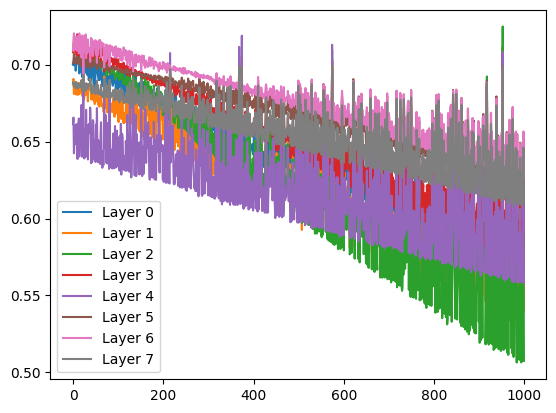

In [38]:


def train(
	model: HookedTransformer,
	dataset: list[str],
	probe_fn: FeatureExtractor,
	batch_size: int = 1,
	device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
) -> HookedTransformer:

	if batch_size != 1:
		# TODO: pls implement batching
		raise NotImplementedError("batch_size > 1 not supported yet")

	# set up model
	model.eval()
	model.to(device)

	# set up probes
	n_layers: int = model.cfg.n_layers

	probes: list[LinearProbe] = [
		LinearProbe(input_dim=model.cfg.d_model, output_dim=1)
		for _ in range(n_layers)
	]
	for probe in probes:
		probe.to(device)
	optimizers: list[torch.optim.Optimizer] = [
		torch.optim.Adam(probe.parameters(), lr=1e-4)
		for probe in probes
	]
	probe_losses: list[list[float]] = [[] for _ in range(n_layers)]

	# training loop
	for idx, text in tqdm(enumerate(dataset), total=len(dataset)):
		# print(unicode_to_ascii(text))
		# get data
		data: BinaryFeatureExtractorOutput = probe_fn(text, TOKENIZER)

		# print(data)
		
		# forward pass, get residuals
		logits, cache = model.run_with_cache(data.input_ids)

		# print(condense_tensor_dict(cache, return_format="yaml"))

		residuals: list[torch.Tensor] = [
			cache[f"blocks.{i}.hook_resid_pre"]
			for i in range(n_layers)
		]

		# train each probe
		for i, probe in enumerate(probes):

			# print(residuals[i][0].shape)
			probe_input = residuals[i][0]
			probe_output = probe(probe_input)[:, 0]
			# print(probe_output.shape)

			# compute cross_entropy loss
			loss = torch.nn.functional.binary_cross_entropy_with_logits(
				probe_output, 
				data.features.float().to(device)
			)

			# backprop
			optimizers[i].zero_grad()
			loss.backward()
			optimizers[i].step()

			# record loss
			probe_losses[i].append(loss.item())

			# if idx % 50 == 0:
			# 	print(f"Layer {i}: {loss.item()}")

	for i, probe_loss in enumerate(probe_losses):
		plt.plot(probe_loss, label=f"Layer {i}")
	plt.legend()
	plt.show()

		
train(
	model=MODEL,
	dataset=TEXT_DATA[:1000],
	batch_size=1,
	probe_fn=in_quotes_no_qmark_feature,
)
